# Grover's algorithm


In [1]:
%pip install qiskit==1.4.2 qiskit-aer==0.16.1

%pip install matplotlib pylatexenc # For visualization

%pip install uv 
!uv pip install 'iqm-client[qiskit]==29.14' 
%pip install lagrangeclient --index-url https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple

from IPython.display import clear_output
clear_output()

First let us take care of the required imports. 

In [2]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator

## Step 1. Map classical inputs to a quantum problem

Grover's algorithm requires an [oracle](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`\*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.


In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search.  In this example we will mark two computational states out of the eight available in a three-qubit computational space:


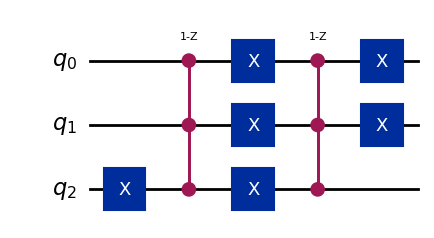

In [4]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle.  Here, we `decompose` the circuit to see the gates within the operator:


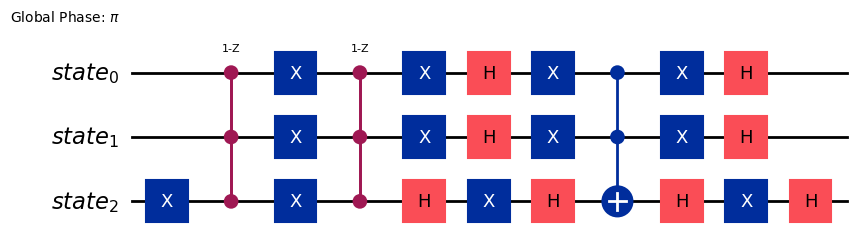

In [5]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:


In [ ]:
N = 2**len(marked_states[0])
theta = math.asin(math.sqrt(len(marked_states) / N))

optimal_num_iterations = math.floor(
    math.pi / (4 * theta)
)

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.


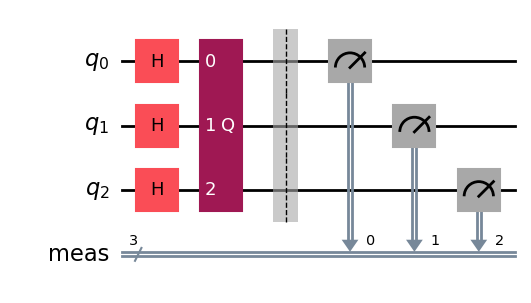

In [7]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2. Optimize problem for quantum execution


### Noiseless Execution

/Users/ema/miniconda3/envs/corso_qc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


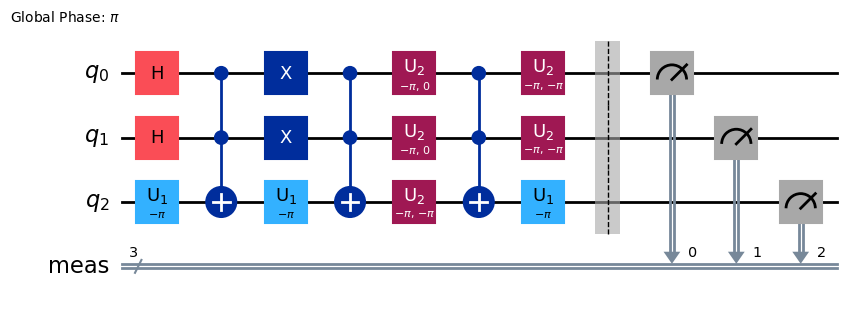

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

transpiler = generate_preset_pass_manager(backend=AerSimulator())
transpiled_circuit = transpiler.run(qc)
transpiled_circuit.draw(output="mpl")

In [9]:
result = AerSimulator().run([transpiled_circuit]).result()
noiseless_dist = result.get_counts()

### Real-Hardware Execution

In [10]:
!lagrangeclient

## On Windows
# import sys
# !{sys.executable} -m lagrangeclient

import json
with open('tokens.json', 'r') as f:
    config = json.load(f)
access_token = config['access_token']

== DEVICE LOGIN FLOW ==
🔗 Visit this URL in your browser:
https://spark.quantum.linksfoundation.com/auth/realms/cortex/device?user_code=OFVI-KONS
Waiting for user to complete login...
=========== TOKEN ===========
eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPN2g5cUtOOGRsdi1OZlo3Qm10NEJNZC0yaUFnMWt5STFEa2h0R3M5OU5rIn0.eyJleHAiOjE3NjI0Mzk4OTEsImlhdCI6MTc2MTgzNTA5MSwiYXV0aF90aW1lIjoxNzYxNjU1MDgyLCJqdGkiOiJvbnJ0ZGc6NzMyYWMyZjAtMWUwOS1hZWJhLWFiMmQtZjYxMjEwYjgwMjE2IiwiaXNzIjoiaHR0cHM6Ly9zcGFyay5xdWFudHVtLmxpbmtzZm91bmRhdGlvbi5jb20vYXV0aC9yZWFsbXMvY29ydGV4IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6IjRjZmJkMGZmLWEwMzktNGZhYS05NDc2LWVjMjFkNTgzZGQ5NSIsInR5cCI6IkJlYXJlciIsImF6cCI6ImlxbV9jbGllbnQiLCJzaWQiOiIyZWRhZTdmNS1hNzkyLTQzNzQtYTM4Ni1lOTI3ODkzYzYwZjUiLCJhY3IiOiIwIiwiYWxsb3dlZC1vcmlnaW5zIjpbImh0dHBzOi8vc3BhcmsucXVhbnR1bS5saW5rc2ZvdW5kYXRpb24uY29tLyoiLCJodHRwczovL2lxbXNwYXJrLnBvbGl0by5pdC8iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbImV4YV9hZG1pbiIsIm9mZmxpbmVfYWNjZXNzIiwicGxhdGZvcm0tYWRtaW4iLCJjb3J0ZXhfYW

In [11]:
from iqm.qiskit_iqm import IQMProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

provider = IQMProvider(url="https://spark.quantum.linksfoundation.com/station", token=access_token)
lagrange_backend = provider.get_backend()

lagrange_pm = generate_preset_pass_manager(backend=lagrange_backend, optimization_level=3)
lagrange_transpiled_circuit = lagrange_pm.run(qc)

station-control-client version '9.18.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


In [12]:
real_hw_result = lagrange_backend.run(lagrange_transpiled_circuit, shots=1024).result()
real_hw_dist = real_hw_result.get_counts()

## Step 3. Post-process, return result in classical format


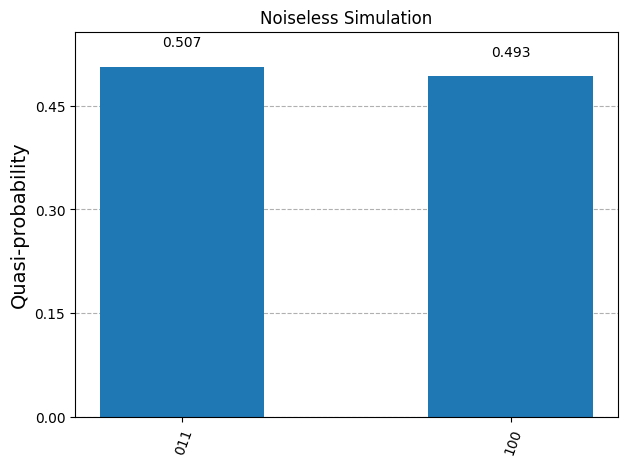

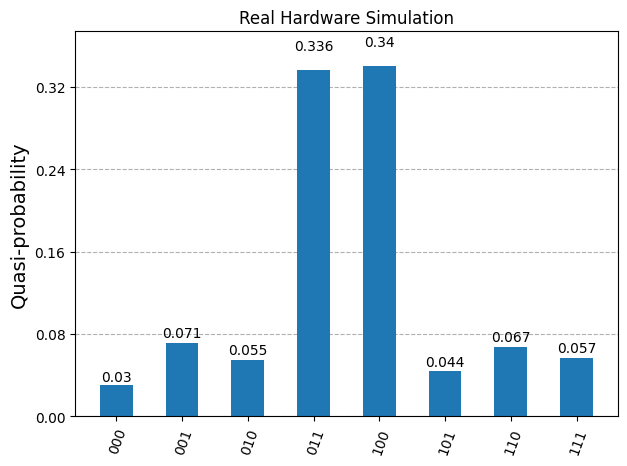

In [13]:
display(plot_distribution(noiseless_dist, title="Noiseless Simulation"))
display(plot_distribution(real_hw_dist, title="Real Hardware Simulation"))